# Network Reconstruction Genetic Algorithm

## 1. Imports

In [30]:
import numpy as np
import random
import networkx as nx
import psutil
from tqdm import tqdm

# importing the frozen network and genetic evolution classes
from network import Frozen_Network, Population
from genetic_algorithm import Genetic_Evolution

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## 2. Configuration

In [2]:
def erdos_renyi(n , p):
    return nx.erdos_renyi_graph(n , p , seed = None)

### 2.1 Target Creation

In [4]:
def randomERNetwork(n):
    p = round(random.uniform(0,1), 2)
    G = erdos_renyi(n, p)

    while not nx.is_connected(G):
        p = round(random.uniform(0,1), 2)
        G = erdos_renyi(n, p)

    return Frozen_Network(nx.to_numpy_array(G).astype("complex"))

### 2.2 Population Creation

In [5]:
# Generating the population of networks
def pop(pop_size, n, mask):
    p = [randomERNetwork(n) for _ in range(pop_size)]
    for network in p:
        network.adjacency_matrix[mask != -1] = mask[mask!= -1]
    return p

In [6]:
def evalutate_network(network, target, pairs, ts, num_steps):
    network.evolution(ts, num_steps, pairs)
    network.calculate_distance(target.sink_data)
    #network.est_adj_distance = adj_dist_est(network.data_ML, network.sink_data, target.sink_data)
    network.calculate_adjacency_distance(target.adjacency_matrix)
    #network.distance = np.sum([regressions[i].predict(scalers[i].transform(np.abs(network.sink_data[i]-target.sink_data[i]).flatten().reshape(1,-1))) for i in range(n)], axis=0)/2
    #vals = np.abs(np.sum(network.sink_data) - np.sum(target.sink_data))
    return None

p = Population([])

def evalutate_population(pop, target, batch_size, pairs, ts, num_steps):
    #for network in [network for network in pop if network.est_adj_distance is None or network.distance is None]:
    #    evalutate_network(network, target, pairs)
    p.networks = [network for network in pop if network.est_adj_distance is None or network.distance is None]
    p.evolvePopulation(ts, num_steps, pairs, batch_size=batch_size)
    p.evaluate(target)
    #for network in p.networ

In [7]:
def createTargetMask(target_adjacency, pairs, n):
    mask = np.zeros((n,n))-1
    for pair in sorted(pairs, key=lambda x: n*x[1]+x[0]):
        if pair[0] != pair[1]:
            mask[pair[0]][pair[1]] = target_adjacency[pair[0]][pair[1]]
            mask[pair[1]][pair[0]] = mask[pair[0]][pair[1]]
    return mask

## 3. Genetic Algorithm

In [8]:
def are_columns_identical_under_permutation(A, B, tol=1e-10):
    #print('perm check')
    if A.shape != B.shape:
        return False
    
    # Represent each column as a tuple for hashing
    col_repr = lambda col: tuple(np.round(col / tol).astype(int))

    # Compute representations
    A_cols = [col_repr(col) for col in A.T]
    B_cols = [col_repr(col) for col in B.T]

    # Sort column representations and compare
    return sorted(A_cols) == sorted(B_cols)

In [9]:
def find_permutation(A, B, tol=1e-10):
    if A.shape != B.shape:
        raise ValueError("Matrices must have the same dimensions.")
    
    # Define a hashing function for columns
    col_hash = lambda col: tuple(np.round(col / tol).astype(int))

    # Create hashed representations of columns
    A_hashes = [col_hash(col) for col in A.T]
    B_hashes = [col_hash(col) for col in B.T]

    permutation_indices = []
    B_hashes_copy = B_hashes.copy()

    for a_hash in A_hashes:
        if a_hash in B_hashes_copy:
            index = B_hashes_copy.index(a_hash)
            permutation_indices.append(index)
            B_hashes_copy[index] = None  # Mark as used
        else:
            raise ValueError("Columns are not actually isomorphic.")
    
    return permutation_indices

In [10]:
def run_alg(target, population, nodes, pop_size, pairs, iterations = 3, early_stopping = -1, batch_size=10000, num_steps=3, mutation_rate=None):
  mask = createTargetMask(target.adjacency_matrix, pairs, nodes)
  peak_time = 2.086*np.exp(-0.131*nodes) + 0.1076
  ts = peak_time/int((num_steps + 1)/2)
  target.evolution(ts, num_steps, pairs)
  evalutate_population(population, target, batch_size, pairs, ts, num_steps)
  population = sorted(population, key = lambda x: x.distance)[:pop_size]
  networks = []
  sink_distances = []
  adj_distances = []
  retain_frac = 0.2
  mutation_frac = 0.9
  extreme_frac = 0.1
  injection_frac = 0.2
  extreme_mutation_prob = 0.1
  if mutation_rate is None:
    mutation_prob = 2/(nodes**2 - nodes - 2*len(pairs))
  else:
    mutation_prob = mutation_rate
  best_dist = 10000
  best_ave_dist = 10000
  early_stopping_counter = 0
  if early_stopping == -1:
    early_stopping = iterations

  if min([network.distance for network in population]) < 10e-8:
    fit_individual = sorted(population, key = lambda x: x.distance)[0]
    return [True, 0, fit_individual, population]
  elif np.min([np.abs(np.sum(np.concatenate(network.sink_data,axis=1)) - np.sum(np.concatenate(target.sink_data, axis=1))) for network in population])<10e-8:
    for j, val in enumerate([np.abs(np.sum(np.concatenate(network.sink_data,axis=1)) - np.sum(np.concatenate(target.sink_data, axis=1))) for network in population]):
      if val < 10e-8:
        if are_columns_identical_under_permutation(np.concatenate(population[j].sink_data, axis=1), np.concatenate(target.sink_data,axis=1), tol=10e-8):
          return [True, 0, population[j], population]

  sink_distances.append([network.distance for network in population])
  adj_distances.append([network.adj_distance for network in population])
  networks.append(population)

  extreme_count = 0
  for i in (range(iterations)):
      #print(f"Current best adjacency dist: {min(adj_distances[-1])}, Current best adjacency dist: {min(sink_distances[-1])}, Average Adj Dist: {np.mean(adj_distances[-1])}, Average Dist: {np.mean(sink_distances[-1])}, Average Connections Error: {np.mean([np.sum(network.adjacency_matrix)//2 for network in population]) - np.sum(target.adjacency_matrix)//2}")
      if i > 20:
        #if all(np.array_equal(population[0].adjacency_matrix, arr.adjacency_matrix) for arr in population[:int(len(population)/4)]):
        #  print('No retention')
        ##  ga = Genetic_Evolution(sorted(population, key=lambda x: x.distance)[:int(len(population)/4)], pop_size=pop_size, mutation_probability=0.2, mutation_fraction=1, retain_frac=0, injection_frac=0)
          # extreme_count = 0
        if extreme_count == 5:
          #print('inject')
          ga = Genetic_Evolution(sorted(population, key=lambda x: x.distance), pop_size=pop_size, mutation_probability=mutation_prob, mutation_fraction=mutation_frac, retain_frac=retain_frac, injection_frac=injection_frac, mask=mask)
          extreme_count = 0
        elif networks[-20][:int(pop_size*extreme_frac)] == networks[-1][:int(pop_size*extreme_frac)]:
          #print('Extreme')
          ga = Genetic_Evolution(sorted(population, key=lambda x: x.distance), pop_size=pop_size, mutation_probability=extreme_mutation_prob, mutation_fraction=mutation_frac, retain_frac=retain_frac, mask=mask)
          extreme_count += 1
        else:
          ga = Genetic_Evolution(sorted(population, key=lambda x: x.distance), pop_size=pop_size, mutation_probability=mutation_prob, mutation_fraction=mutation_frac, retain_frac=retain_frac, mask=mask)
          extreme_count = 0
      else:
        ga = Genetic_Evolution(sorted(population, key=lambda x: x.distance), pop_size=pop_size, mutation_probability=mutation_prob, mutation_fraction=mutation_frac, retain_frac=retain_frac, mask=mask)
        extreme_count = 0
      ga.mate_population()
      ga.mutate_population()
      population = ga.new_population
      evalutate_population(population, target, batch_size, pairs, ts, num_steps)
      sink_distances.append(sorted([network.distance for network in population]))
      adj_distances.append([network.adj_distance for network in population])
      networks.append(population)
      if min(sink_distances[-1]) < 10e-8:
        fit_individual = sorted(population, key = lambda x: x.distance)[0]
        #print("converged")
        return [True, i, fit_individual, population]
      elif np.min([np.abs(np.sum(np.concatenate(network.sink_data, axis=1)) - np.sum(np.concatenate(target.sink_data, axis=1))) for network in population])<10e-8:
        for j, val in enumerate([np.abs(np.sum(np.concatenate(network.sink_data, axis=1)) - np.sum(np.concatenate(target.sink_data, axis=1))) for network in population]):
            if val < 10e-8:
              #print(nx.is_isomorphic(nx.Graph(population[j].adjacency_matrix), nx.Graph(target.adjacency_matrix)))
              if are_columns_identical_under_permutation(np.concatenate(population[j].sink_data, axis=1), np.concatenate(target.sink_data,axis=1), tol=10e-8):
                return [True, i, population[j], population]
      if min(sink_distances[-1]) >= best_dist and np.mean(sink_distances[-1][:int(pop_size/10)]) >= best_ave_dist:
        early_stopping_counter += 1
      
      if min(sink_distances[-1]) < best_dist:
        best_dist = min(sink_distances[-1])
        fit_individual = sorted(population, key = lambda x: x.distance)[0]
        early_stopping_counter = 0
      if np.mean(sink_distances[-1][:int(pop_size/10)]) < best_ave_dist:
        best_ave_dist = np.mean(sink_distances[-1][:int(pop_size/10)])
        early_stopping_counter = 0
    
      if early_stopping_counter > early_stopping:
          return [False, i, fit_individual, population]
      #for network in population:
        #  if network.est_adj_distance < 5:
          #    found = same_under_permutation_sorting(network.sink_data, target.sink_data)
            #  if found:
              #    print("Converged!")
                #  return [True, i, networks]
  else:
      fit_individual = sorted(population, key = lambda x: x.distance)[0]
      #print("No fit individual found within iteration limit")

  return [False, iterations, fit_individual, population, networks]

In [11]:
results = []
iters = []
targets = []
networks = []

In [12]:
import pickle
import os

# Function to append a single object
def append_object(filename, obj):
    with open(filename, "ab") as f:  # Open in append binary mode
        pickle.dump(obj, f)

# Function to load all objects without rewriting the file
def load_objects(filename):
    objects = []
    if not os.path.exists(filename):
        return objects  # Return empty list if file does not exist
    
    with open(filename, "rb") as f:
        while True:
            try:
                objects.append(pickle.load(f))  # Load one object at a time
            except EOFError:
                break  # Stop when reaching the end of file
    return objects



### 3.1 Population Analysis

In [13]:
dims = np.arange(6,10)

In [14]:
dims

array([6, 7, 8, 9])

In [15]:
pop_sizes = [[10,50], [10,200], [10, 500], [10, 1000]]

In [16]:
import copy

In [19]:

num_samples = 1

for samp in (range(num_samples)):
    for i, dim in enumerate(tqdm(dims)):
        pairs = [(0,i) for i in range(dim)]
        target = randomERNetwork(dim)
        append_object(f'population_data_targets/targets{dim}.pkl', target)
        pop_list = (10**(np.linspace(np.log10(pop_sizes[i][0]), np.log10(pop_sizes[i][1]), 81))).astype(int)[::2]
        mask = createTargetMask(target.adjacency_matrix, pairs, dim)
        population = pop(np.max(pop_list), dim, mask)
        for pop_size in pop_list:
            result = run_alg(target, copy.deepcopy(population[:pop_size]), dim, pop_size, pairs, 200, early_stopping=50)
            #if not result[0]:
            #    result = run_alg(target, copy.deepcopy(population[:pop_size]), dim, pop_size, pairs, 1000, early_stopping=50)
            #print(result[0], result[1], result[2].adj_distance, nx.is_isomorphic(nx.Graph(target.adjacency_matrix), nx.Graph(result[2].adjacency_matrix)))
            append_object(f'population_data/iters{dim}_{pop_size}.pkl', result[1])
            append_object(f'population_data/results{dim}_{pop_size}.pkl', result[2])
            append_object(f'population_data/targets{dim}_{pop_size}.pkl', target)
            append_object(f'population_data/populations{dim}_{pop_size}.pkl', result[3])

  0%|          | 0/4 [00:00<?, ?it/s]2025-05-02 09:30:54.279845: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-05-02 09:30:54.279884: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-02 09:30:54.279894: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-02 09:30:54.279931: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-02 09:30:54.279949: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-05-02 09:30:54.488685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is

In [20]:
def load_objects(filename):
    objects = []
    if not os.path.exists(filename):
        return objects  # Return empty list if file does not exist
    
    with open(filename, "rb") as f:
        while True:
            try:
                objects.append(pickle.load(f))  # Load one object at a time
            except EOFError:
                break  # Stop when reaching the end of file
    return objects

In [21]:
iters_file = f'population_data/iters{dim}_{pop_size}.pkl'
results_file = f'population_data/results{dim}_{pop_size}.pkl'
targets_file = f'population_data/targets{dim}_{pop_size}.pkl'
populations_file = f'population_data/populations{dim}_{pop_size}.pkl'

results = load_objects(results_file)
iters = load_objects(iters_file)
targets = load_objects(targets_file)

In [22]:
len(targets)

3501

In [23]:
nodes = list(set([int(file.split('_')[0].split('s')[-1]) for file in os.listdir('population_data') if file != '.DS_Store']))
pop_sizes = list(set([int(file.split('_')[1].split('.')[0]) for file in os.listdir('population_data') if file != '.DS_Store']))

In [24]:
performances = []
pop_size_sets = []

for node in nodes:
    performances.append([])
    pop_size_sets.append([])
    for pop_size in pop_sizes:
        if f'results{node}_{pop_size}.pkl' in os.listdir('population_data'):
            resss = load_objects(f'population_data/results{node}_{pop_size}.pkl')
            targss = load_objects(f'population_data/targets{node}_{pop_size}.pkl')
            performances[-1].append(len([x for i, x in enumerate(resss) if are_columns_identical_under_permutation(np.concatenate(targss[i].sink_data, axis=1), np.concatenate(x.sink_data, axis=1))])/len(targss))
            #performances[-1].append(len([x for i, x in enumerate(resss) if nx.is_isomorphic(nx.Graph(targss[i].adjacency_matrix), nx.Graph(x.adjacency_matrix))])/len(targss))
            pop_size_sets[-1].append(pop_size)


Text(0.5, 0, 'Population Size')

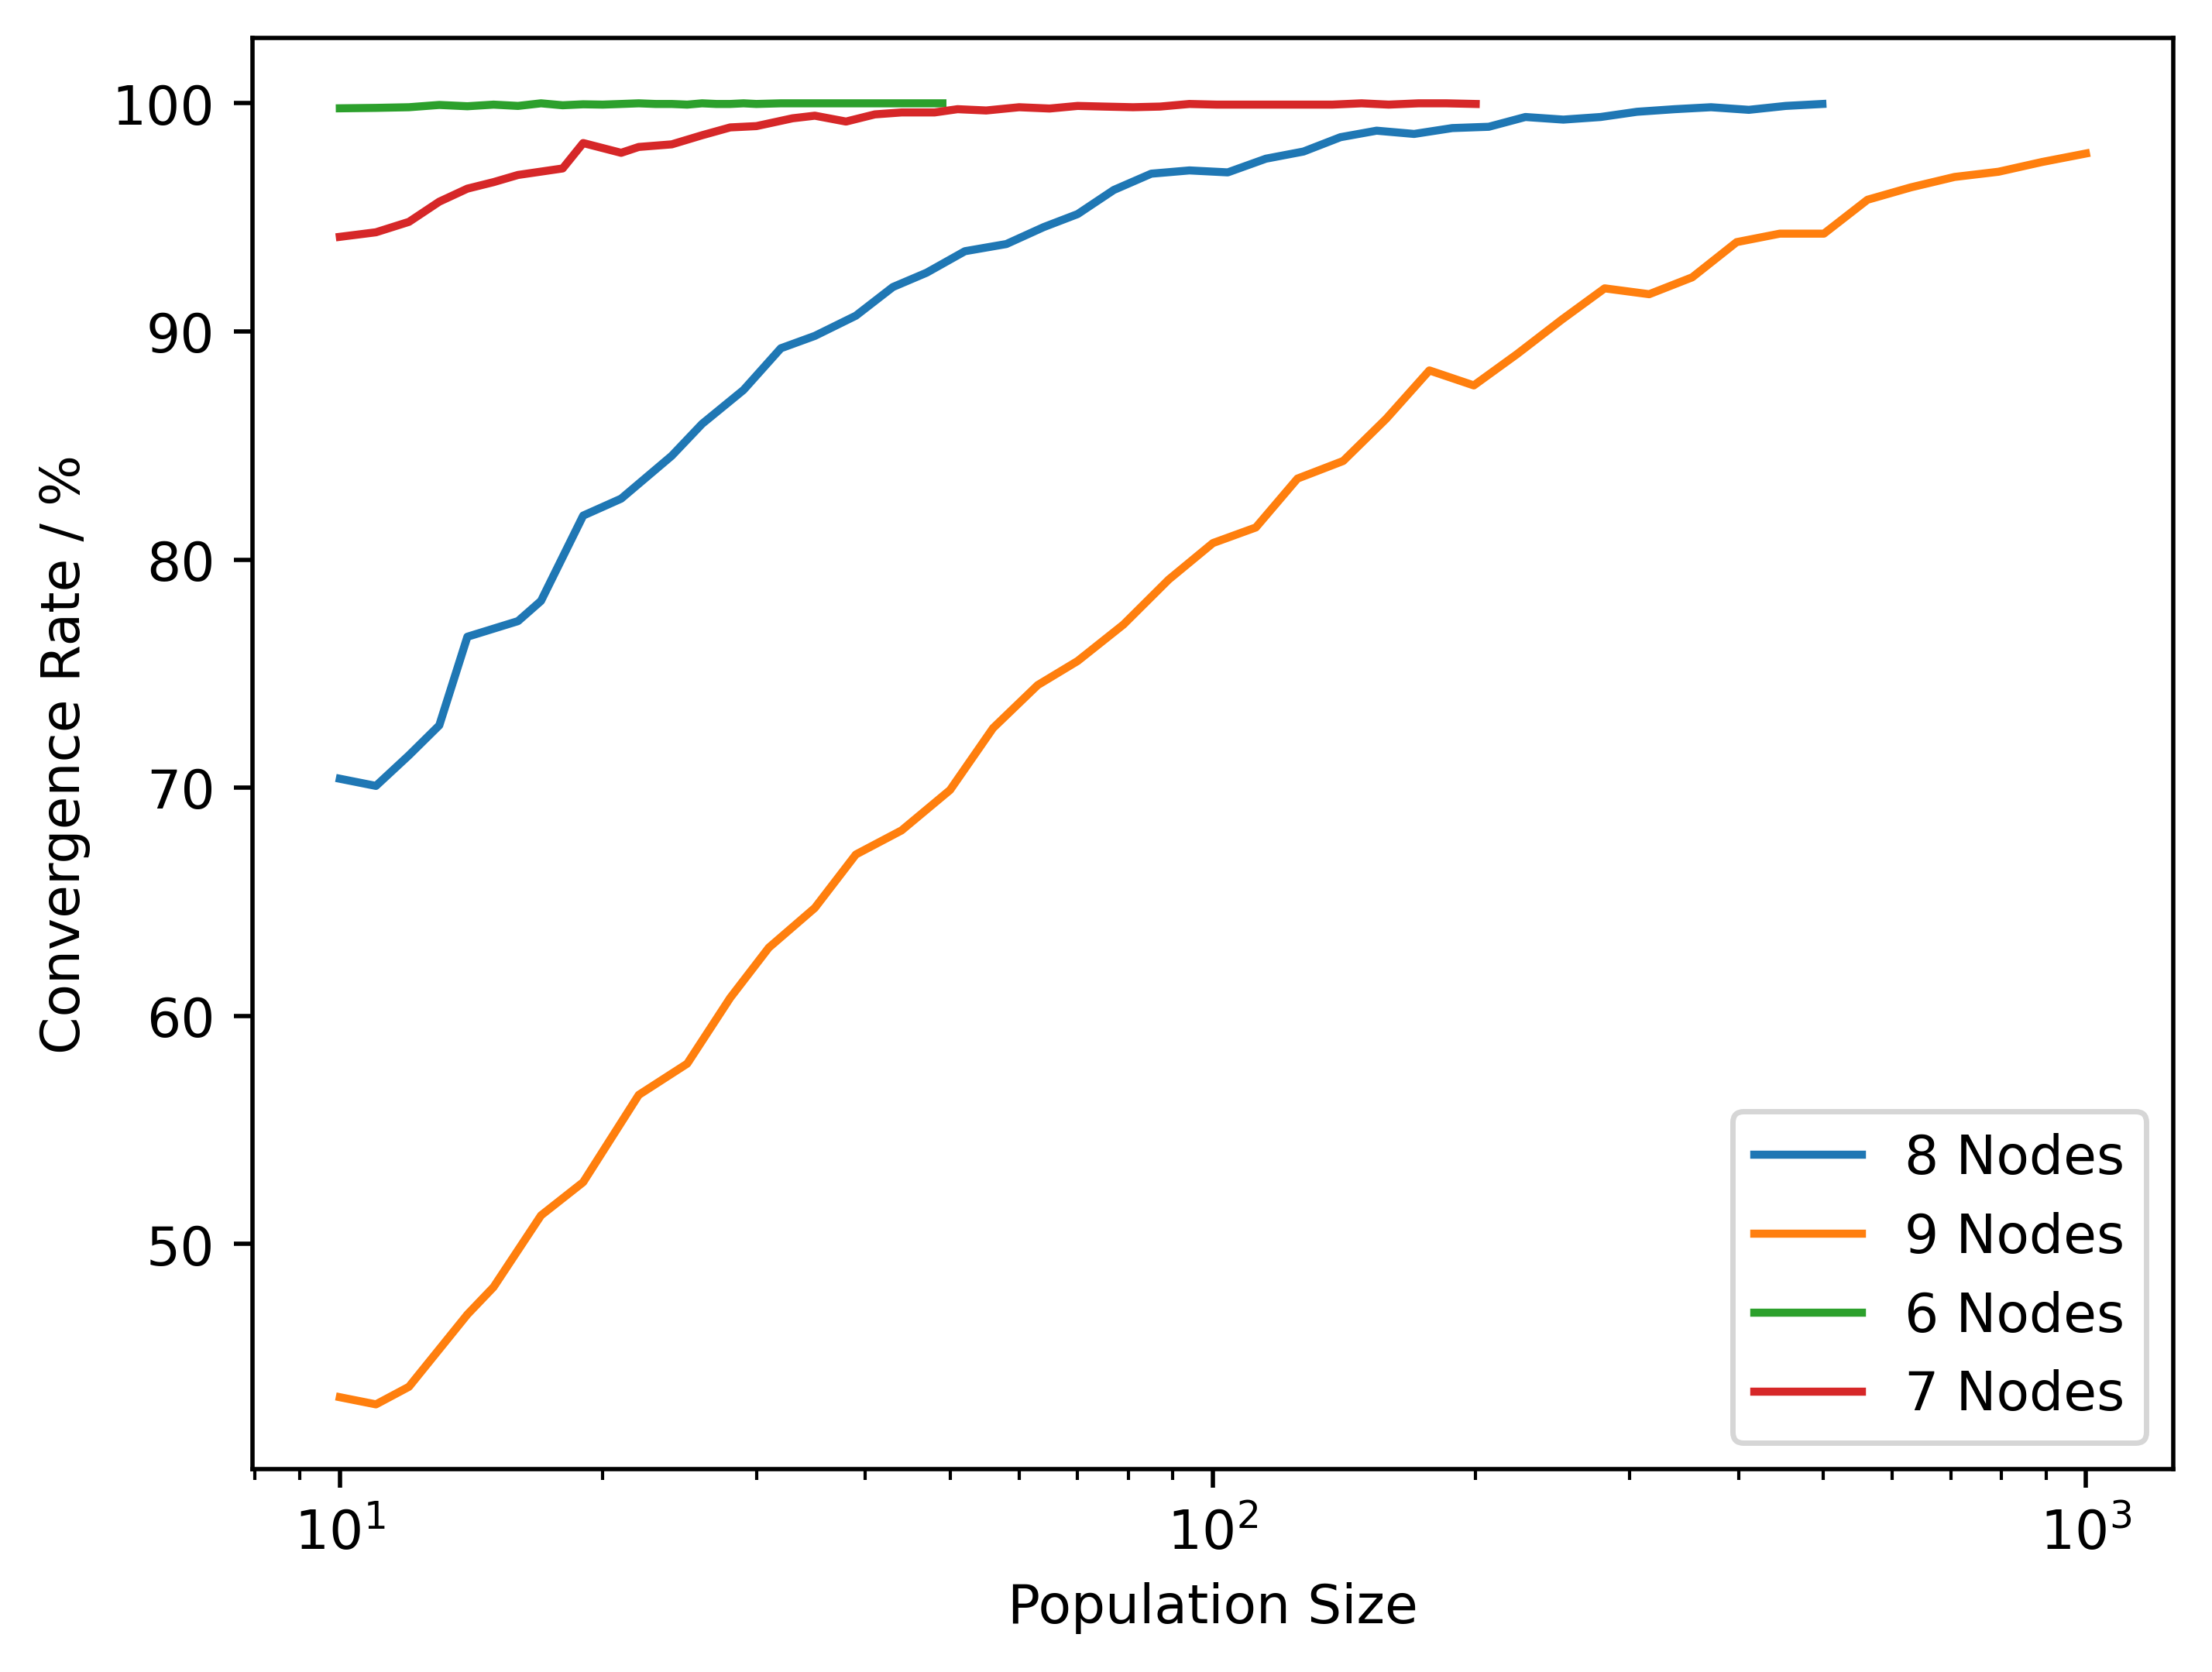

In [26]:
import matplotlib.pyplot as plt

plt.figure(dpi=500)
for i, node in enumerate(nodes):
    data = sorted(zip(pop_size_sets[i], performances[i]), key=lambda x: x[0])
    plt.plot([x[0] for x in data], [x[1]*100 for x in data], label=f'{node} Nodes')

plt.xscale('log')

plt.legend()
plt.ylabel('Convergence Rate / %')
plt.xlabel('Population Size')

In [28]:
performances = []
pop_size_sets = []

for node in nodes:
    performances.append([])
    pop_size_sets.append([])
    for pop_size in pop_sizes:
        if f'results{node}_{pop_size}.pkl' in os.listdir('population_data'):
            resss = load_objects(f'population_data/iters{node}_{pop_size}.pkl')
            performances[-1].append(np.mean([val for val in resss]))
            pop_size_sets[-1].append(pop_size)


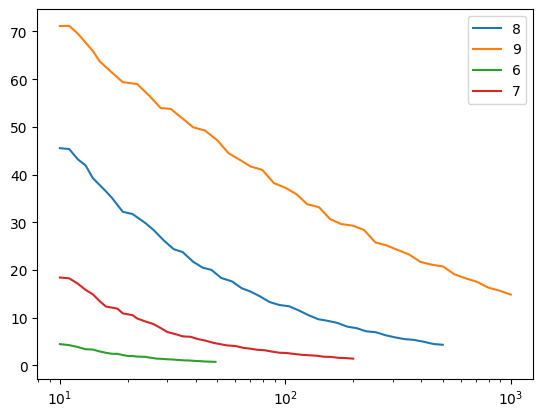

In [29]:
import matplotlib.pyplot as plt
for i, node in enumerate(nodes):
    data = sorted(zip(pop_size_sets[i], performances[i]), key=lambda x: x[0])
    plt.plot([x[0] for x in data], [x[1] for x in data], label=node)
plt.legend()
plt.xscale('log')